# Визуализация данных
Проведём первичную статистику и познакомимся с данными

## Подготовка к работе
Оптимизируем дальнейший код и сразу заполним пространство всем необходимым функционалом.

In [1]:
import os

import geopandas as gpd
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
def check_folder_name(folder_name: str) -> str:
    """If folder not exists - create, after return path"""

    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    return folder_name

In [2]:
FIG_SIZE = (38.4,21.6)  # 3810x2160

NATURALEARTH_NAME = 'map.zip'
IMF_NAME = 'imf.csv'

SOURCE_PATH = 'data/source'
MERGED_PATH = 'data/merged'
LIGHT_PATH = 'data/light'
VISUAL_PATH = check_folder_name('visual')

In [4]:
sns.set_theme(palette='winter', font='jost', font_scale=3, rc={'figure.figsize': FIG_SIZE})

## Визуализация данных от IMF

Для начала возьмём уже подготовленные в блокноте `prepare` данные по геометкам стран и ВВП по ППС

In [5]:
imf_df: pd.DataFrame = pd.read_csv(f'{SOURCE_PATH}/{IMF_NAME}', index_col='iso_a3')
imf_df.head()

,year,label,income,group
iso_a3,,,,
ALB,2019,Albania,14293.306627,Upper-middle income
DZA,2019,Algeria,11455.135742,Lower-middle income
AGO,2019,Angola,5882.390932,Lower-middle income
ATG,2019,Antigua and Barbuda,22773.819265,Upper-middle income
ABW,2019,Aruba,40003.319498,High income


In [6]:
map_df: gpd.GeoDataFrame = gpd.read_file(f'{SOURCE_PATH}/{NATURALEARTH_NAME}')[['ISO_A3', 'NAME_LONG', 'geometry']]

map_df.set_index('ISO_A3', inplace=True)
map_df.to_crs(epsg=3857, inplace=True)
map_df.drop(index='ATA', inplace=True)  # remove Antarctica

map_df.head()

,NAME_LONG,geometry
ISO_A3,,
IDN,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102..."
MYS,Malaysia,"MULTIPOLYGON (((13102705.696 463877.598, 13101..."
CHL,Chile,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77..."
BOL,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828...."
PER,Peru,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77..."


Визуализируем набор имеющихся стран - построим карту, на которой отобразится распределение ВВП по ППС по странам.
Отберём наблюдения за 2022 год

In [7]:
imf_2022: gpd.GeoDataFrame = map_df.join(imf_df[imf_df['year'] == 2022], how='left')

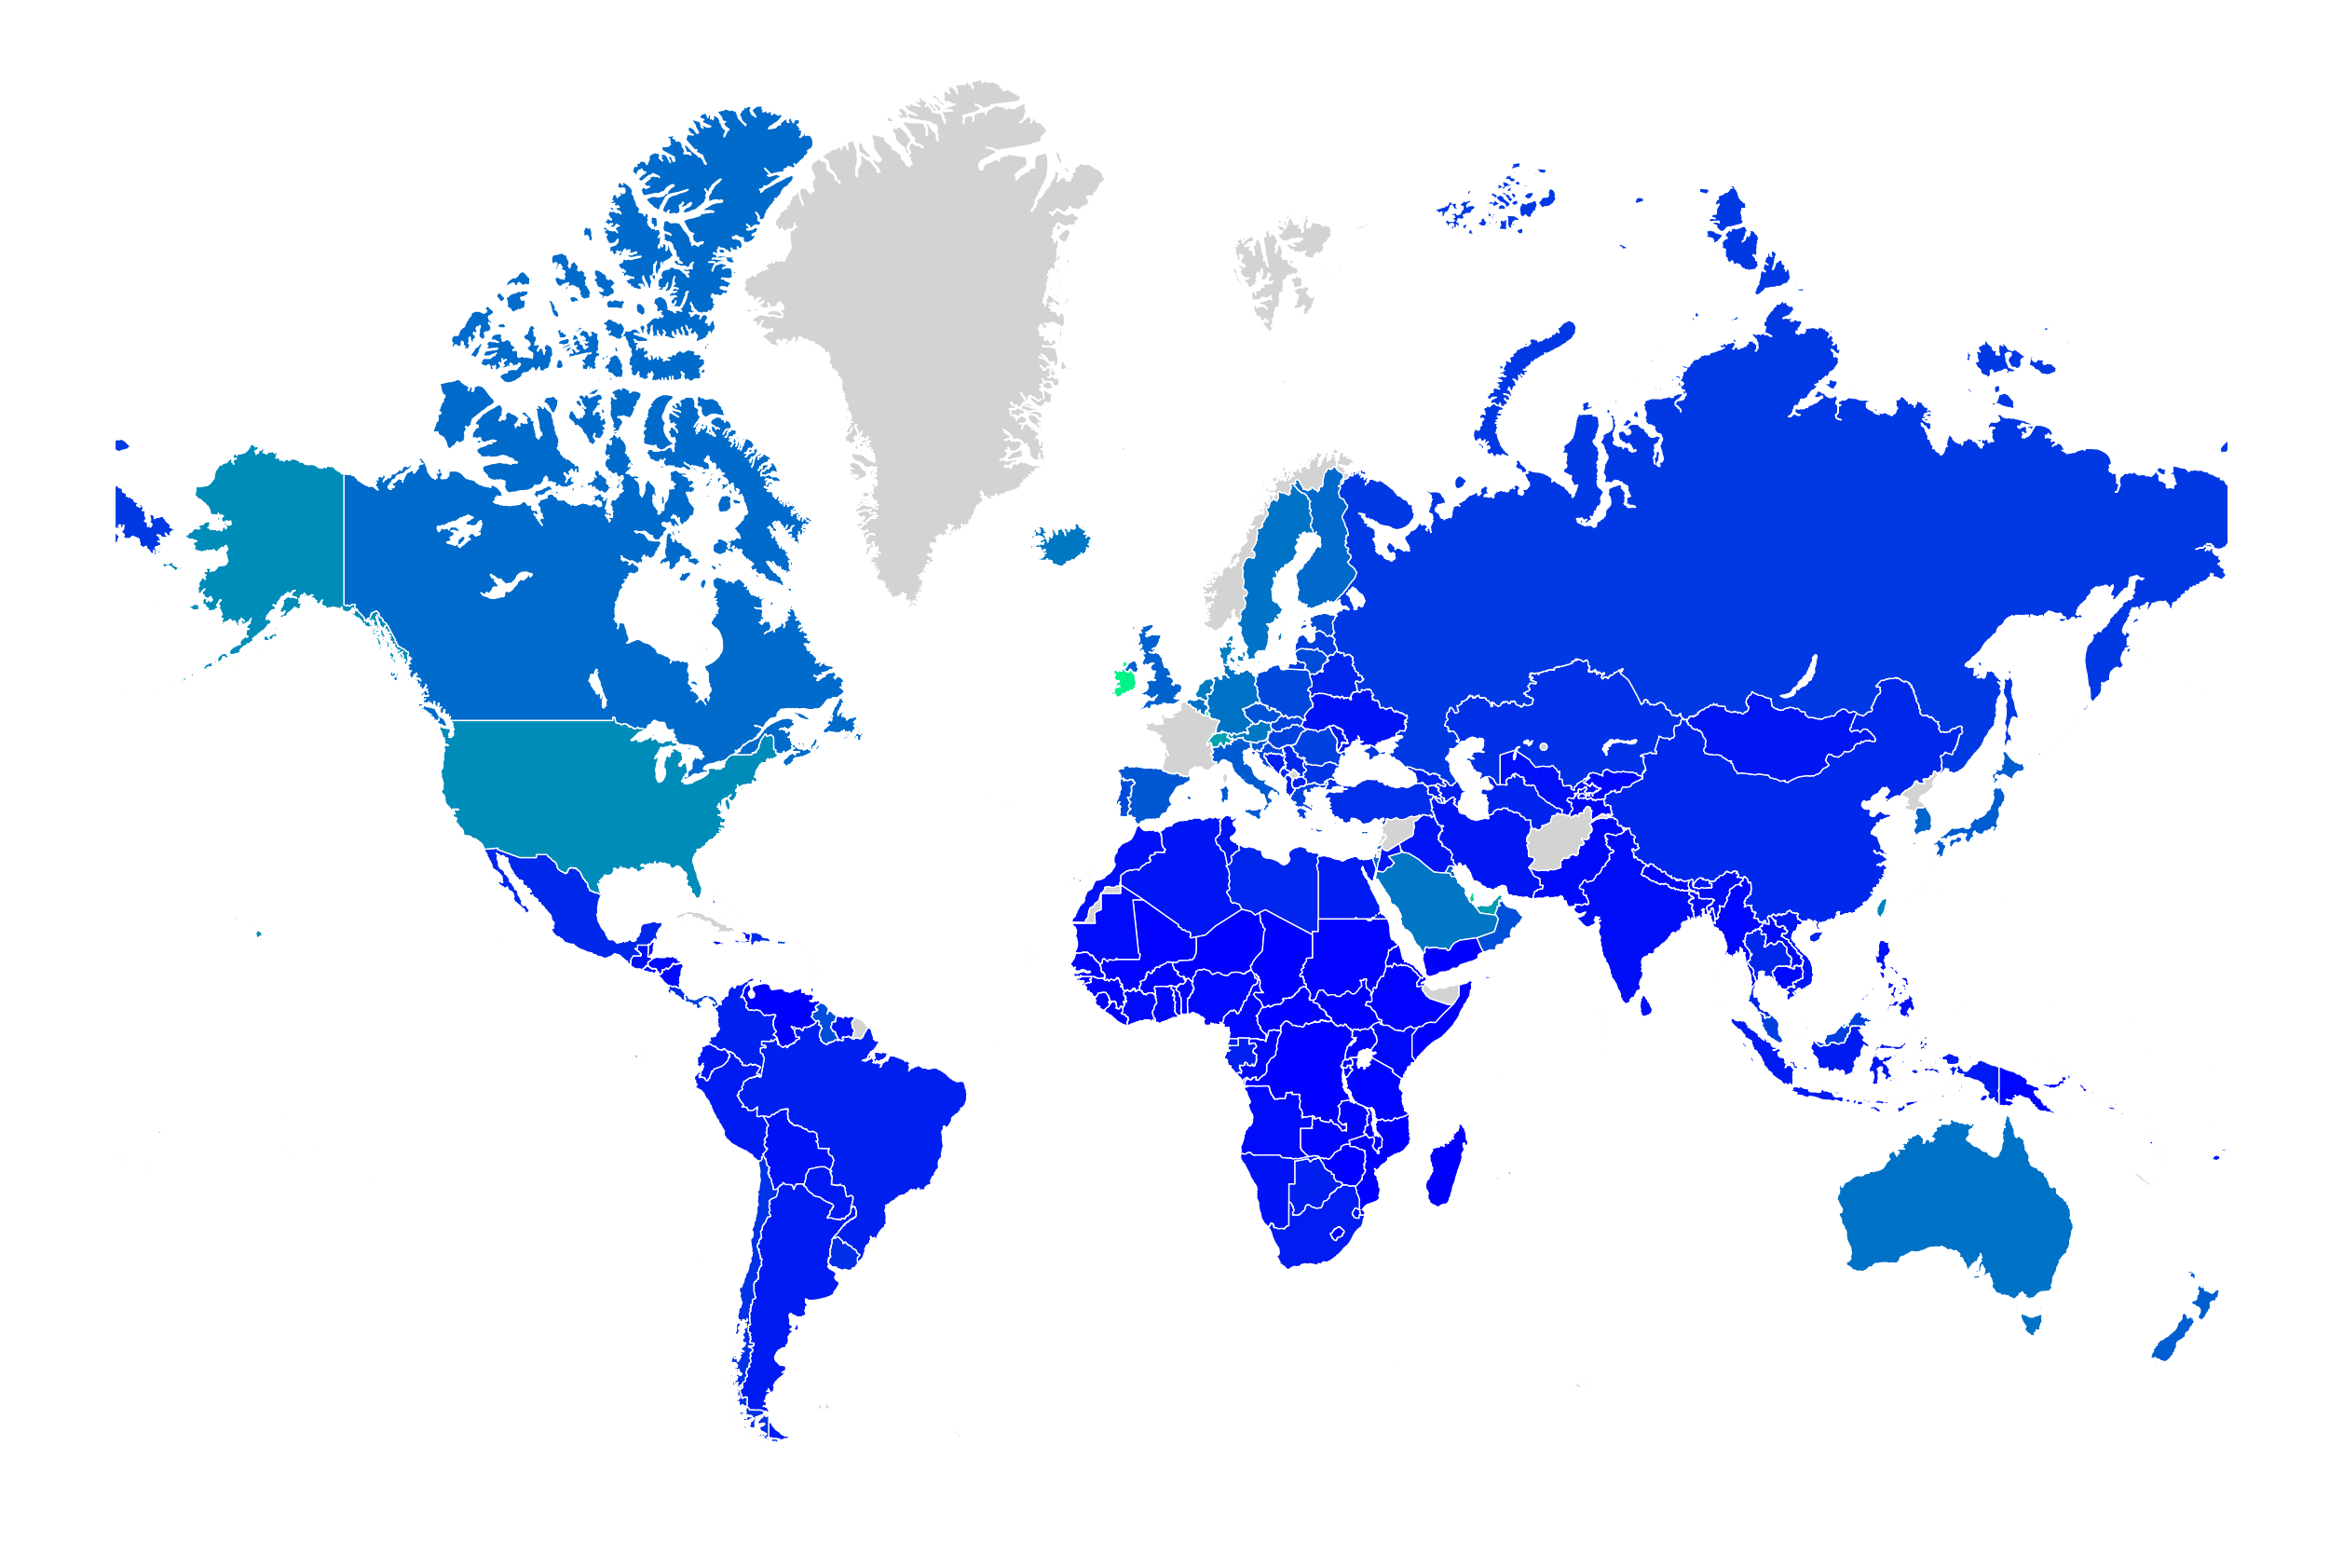

In [8]:
imf_plot_map = imf_2022.plot(column='income', cmap='winter', missing_kwds={'color': 'lightgrey'})
imf_plot_map.set_axis_off();

Сохраним карту

In [9]:
imf_plot_map.figure.savefig(f'{VISUAL_PATH}/imf_map.png', transparent=True)

Как видно, в выборку не вошли такие страны, как Франция, Норвегия, Северная Корея, Куба и некоторые другие:

In [10]:
imf_2022[imf_2022['income'].isnull()]['NAME_LONG'].unique()

array(['Dhekelia', 'Somaliland', 'France', 'Norway', 'Kosovo',
       'US Naval Base Guantanamo Bay', 'Brazilian Island',
       'Northern Cyprus', 'Cyprus U.N. Buffer Zone', 'Siachen Glacier',
       'Baikonur Cosmodrome', 'Akrotiri', 'Southern Patagonian Ice Field',
       'Bir Tawil', 'Indian Ocean Territories', 'Coral Sea Islands',
       'Spratly Islands', 'Clipperton Island',
       'Ashmore and Cartier Islands', 'Bajo Nuevo Bank (Petrel Islands)',
       'Serranilla Bank', 'Scarborough Reef', 'Afghanistan', 'Anguilla',
       'Åland Islands', 'American Samoa',
       'French Southern and Antarctic Lands', 'Saint-Barthélemy',
       'Bermuda', 'Cook Islands', 'Cuba', 'Curaçao', 'Cayman Islands',
       'Western Sahara', 'Falkland Islands / Malvinas', 'Faeroe Islands',
       'Guernsey', 'Gibraltar', 'Greenland', 'Guam',
       'Heard I. and McDonald Islands', 'Isle of Man',
       'British Indian Ocean Territory', 'Jersey', 'Lebanon',
       'Liechtenstein', 'Saint-Martin', 'Mona

## Визуализация данных от Ookla
Возьмём данные за 2022 год

### fixed
Начнём с данных, основанных на стационарных каналах

#### Карты
Подключим датасет с геометками и отобразим его на карте

In [11]:
fixed_2022: gpd.GeoDataFrame = gpd.read_file(f'{LIGHT_PATH}/fixed/2022_fixed_light')

fixed_2022.set_index('iso_a3', inplace=True)
fixed_2022.sort_values(by='income', inplace=True)
fixed_2022.set_geometry(fixed_2022.boundary, inplace=True)  # optimize geometry
fixed_2022.to_crs(epsg=3857, inplace=True)

fixed_2022.head()

,year,label,income,group,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
iso_a3,,,,,,,,,,
SSD,2022,"South Sudan, Republic of",342.252475,Low income,3025.5,2773.00,72.50,2356,653,"MULTILINESTRING ((3413371.935 456176.185, 3413..."
BDI,2022,Burundi,676.002370,Low income,7270.0,6766.00,23.75,3543,795,"MULTILINESTRING ((3265389.848 -420097.907, 326..."
ZWE,2022,Zimbabwe,733.842059,Low income,5375.0,2687.00,40.00,26336,7078,"MULTILINESTRING ((3127191.701 -2435589.469, 31..."
CAF,2022,Central African Republic,1001.101946,Low income,2492.5,860.00,769.00,171,46,"MULTILINESTRING ((2064411.260 487362.492, 2064..."
COD,2022,"Congo, Dem. Rep. of the",1227.934105,Low income,9994.0,3348.75,72.00,7414,2505,"MULTILINESTRING ((1497554.258 -650020.489, 149..."


In [12]:
fixed_2022.describe()

,year,income,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
count,189.0,189.000000,189.000000,189.000000,189.000000,1.890000e+02,1.890000e+02
mean,2022.0,23376.948740,42036.598325,22772.361993,40.303571,2.712623e+06,7.541267e+05
std,0.0,24751.065288,47336.837754,32929.418180,105.478427,8.106548e+06,2.285693e+06
min,2022.0,342.252475,1532.000000,282.000000,3.750000,2.500000e+01,1.100000e+01
25%,2022.0,4871.203627,9950.000000,4740.500000,11.000000,1.874200e+04,6.405000e+03
50%,2022.0,13921.402844,21212.000000,10454.625000,18.000000,2.688110e+05,7.999300e+04
75%,2022.0,36184.044878,55071.000000,24685.041667,26.000000,1.455406e+06,4.526130e+05
max,2022.0,130002.858890,247958.250000,215361.125000,769.000000,7.823475e+07,2.344129e+07


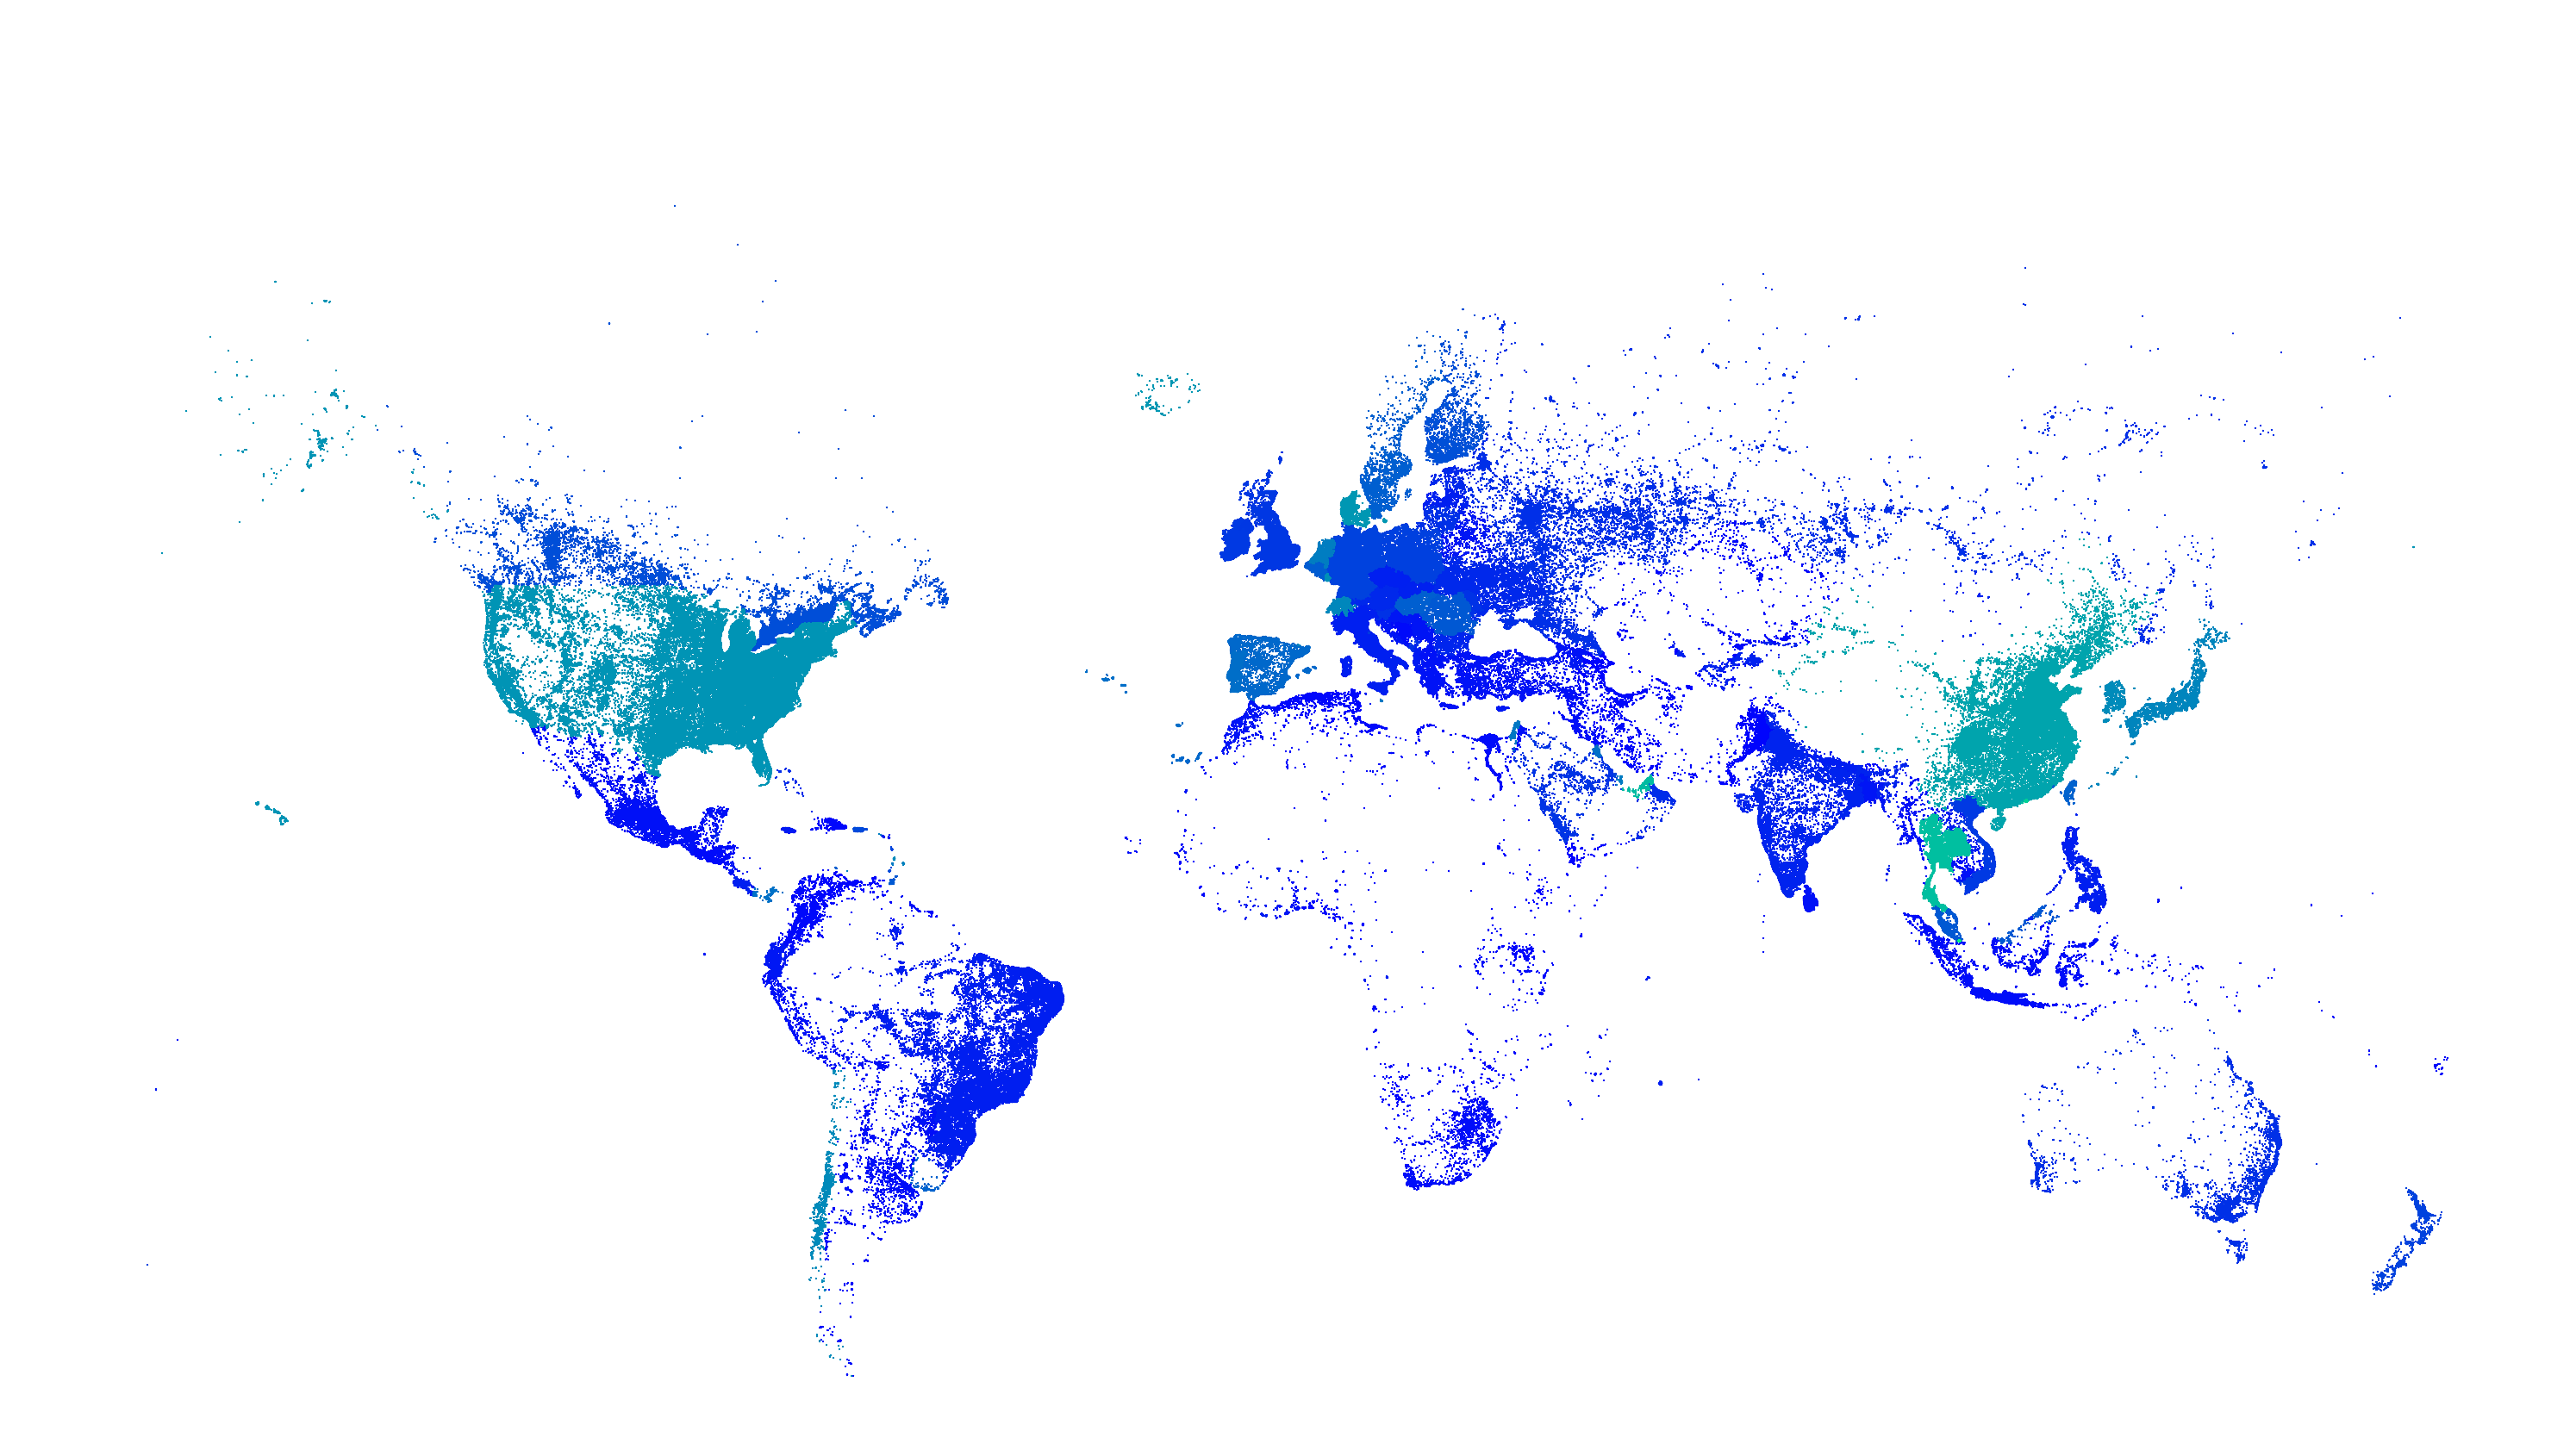

In [13]:
fixed_plot_map = fixed_2022.plot(column='avg_d_kbps', cmap='winter')
fixed_plot_map.set_axis_off();

Сохраним карту

In [14]:
fixed_plot_map.figure.savefig(f'{VISUAL_PATH}/fixed_map.png', transparent=True)

#### Диаграммы
Проведём первичный графический анализ датасета

Для начала рассмотрим распределение каждого показателя

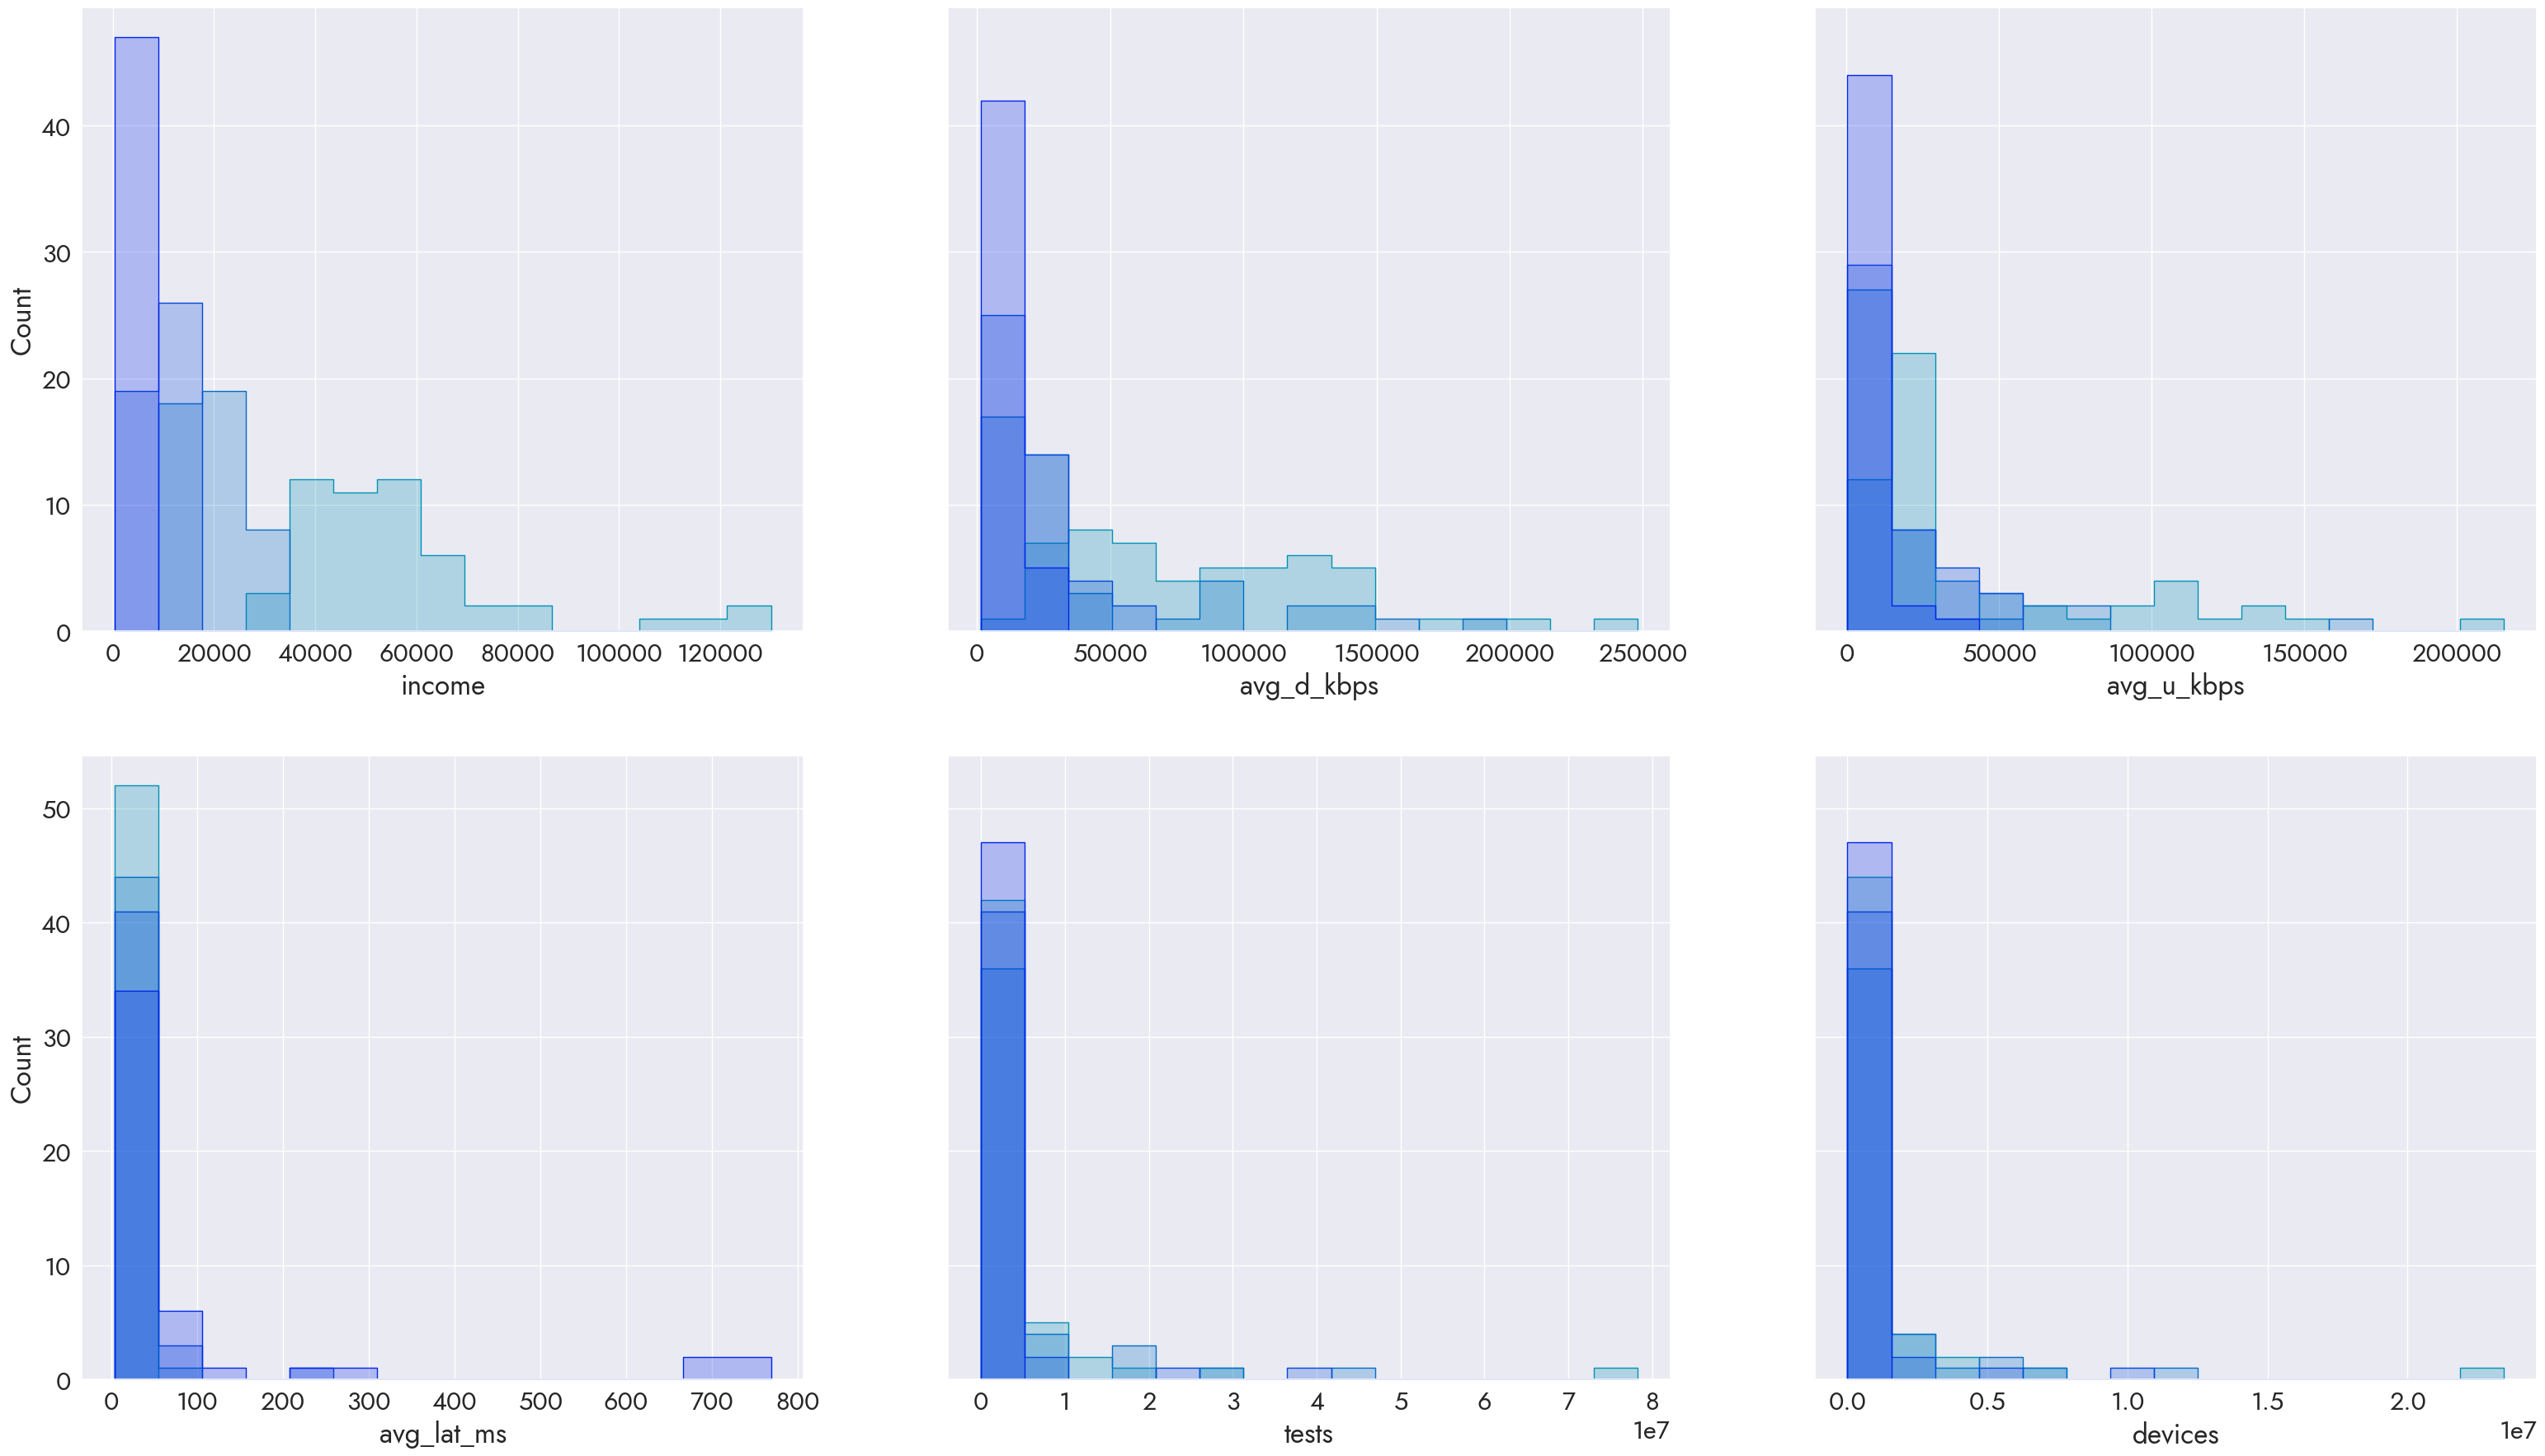

In [15]:
columns = np.delete(fixed_2022.columns, [0, 1, 3, 9])  # columns without ['year', 'label', 'group', 'geometry']
fig, axs = plt.subplots(2, 3, sharey='row')

for column, ax in zip(columns, axs.flat):
    sns.histplot(data=fixed_2022, x=column, hue='group', element='step', legend=False, bins=15, ax=ax)

In [16]:
fig.savefig(f'{VISUAL_PATH}/fixed_hist.png', transparent=True)

Выведем сводную диаграмму для попарного анализа признаков. Чтобы вычесть влияние неоднородного масштаба показателей, логарифмируем их.

In [17]:
for column in columns:
    fixed_2022[column] = np.log(fixed_2022[column])

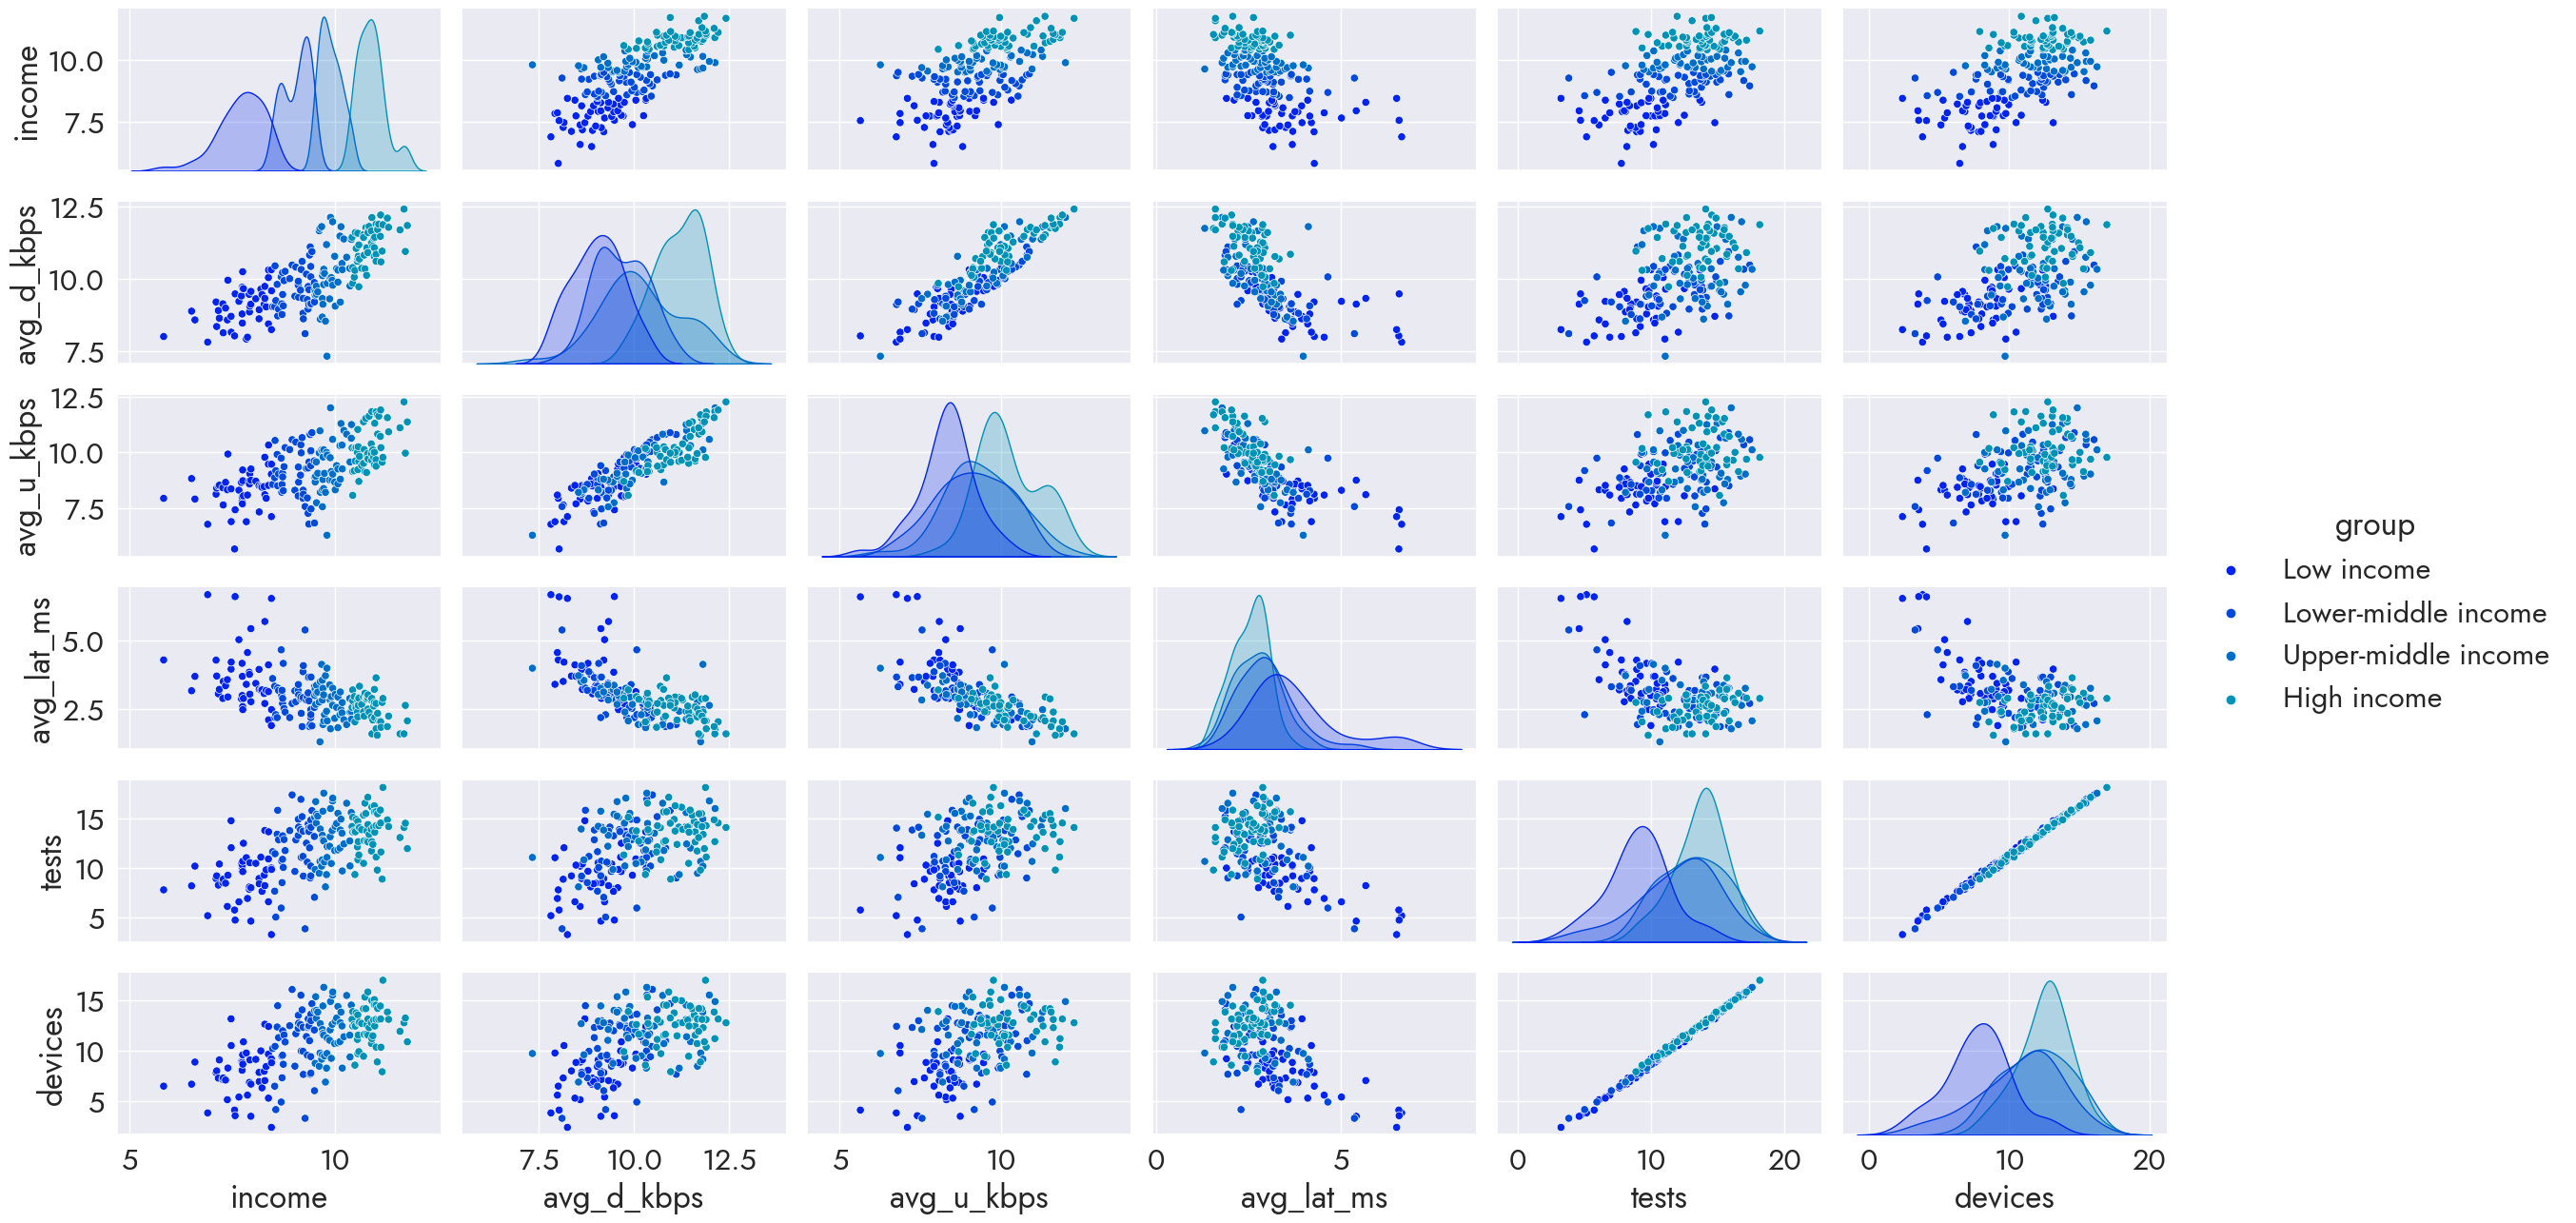

In [18]:
fixed_plot_pair = sns.pairplot(data=fixed_2022, vars=columns, hue='group', height=FIG_SIZE[1] / 3 * 9 / 16, aspect=16 / 9)

Как видно по сводной диаграмме, между показателями Ookla и IMF наблюдается корреляция - тренд распределения расположен возле диагоналей.
При этом также наблюдается тесная связь между показателями скорости загрузки, скачивания и задержки сети, а также между количеством тестов и устройств. Однако между этими двумя группами показателей корреляция слабая.

In [19]:
fixed_plot_pair.savefig(f'{VISUAL_PATH}/fixed_pair.png', transparent=True)